# Capturing neutral face video

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook

import os, sys
import yaml
from argparse import ArgumentParser

import imageio
import numpy as np
from skimage.transform import resize
from skimage import img_as_ubyte
import torch

import pdb
#import pyvirtualcam
import time
from calibration.undistort import undistort
import cv2

import face_alignment
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cpu', face_detector='blazeface')

USE_RECORDED_VIDEO = True
MERGE_HEIGHT = 128
def crop_image(image):
    return image[:,80:-80,:]

if sys.version_info[0] < 3:
    raise Exception("You must use Python 3 or higher. Recommended version is Python 3.7")

def draw_marks(image, marks, color=(0, 255, 0)):
    """
    Draw the facial landmarks on an image
    Parameters
    ----------
    image : np.uint8
        Image on which landmarks are to be drawn.
    marks : list or numpy array
        Facial landmark points
    color : tuple, optional
        Color to which landmarks are to be drawn with. The default is (0, 255, 0).
    Returns
    -------
    None.
    """
    for mark in marks:
        cv2.circle(image, (mark[0], mark[1]), 2, color, -1, cv2.LINE_AA)    

def pre_process_frame(frame, crop = True, cvt_color = True):
    #frame = frame[:,80:-80,:]
    if crop:
        frame = crop_image(frame)
    frame = cv2.resize(frame,(256,256))
    if cvt_color:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
    frame = [resize(img, (256, 256))[..., :3] for img in [frame]]
    return frame

Downloading: "https://github.com/hollance/BlazeFace-PyTorch/blob/master/blazeface.pth?raw=true" to /home/hppeng/.cache/torch/hub/checkpoints/blazeface.pth


  0%|          | 0.00/410k [00:00<?, ?B/s]

Downloading: "https://github.com/hollance/BlazeFace-PyTorch/blob/master/anchors.npy?raw=true" to /home/hppeng/.cache/torch/hub/checkpoints/anchors.npy


  0%|          | 0.00/28.1k [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /home/hppeng/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip


  0%|          | 0.00/91.9M [00:00<?, ?B/s]

In [3]:
#source_image = (imageio.imread('./init_img2.png')).astype(np.uint8)
reader2 = cv2.VideoCapture('./init_video.mp4')
driving_video = []
regular_video = []


while(1):
    ret,frame = reader2.read()
    if(ret):
        regular_video.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    else:
        break

## first image of the natural blinking video
#source_image = resize(source_image, (256, 256))[..., :3]
## resize the natural blinking video 
regular_video = [resize(frame, (256, 256))[..., :3] for frame in regular_video]

if not USE_RECORDED_VIDEO:
    ## make sure camera is working 
    cap = cv2.VideoCapture(0)
    res, frame = cap.read()
    while(res is not True):
        res, frame = cap.read()
        print('retry')
        time.sleep(0.3)
    driving_video = pre_process_frame(frame)
else:
    saved_video_reader = cv2.VideoCapture('./video_headset_on.mp4')
    saved_video = []
    while(1):
        ret,frame = saved_video_reader.read()
        if(ret):
            saved_video.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        else:
            break
    driving_video = pre_process_frame(saved_video[0], crop =False, cvt_color = False)

print(len(regular_video), len(saved_video))

439 602


[[ 81.57367706  65.08187866 193.54692078 177.05535889   0.91667873]]
[ 78.73709484  62.39492918 190.79710631 174.45556224]


<IPython.core.display.Javascript object>


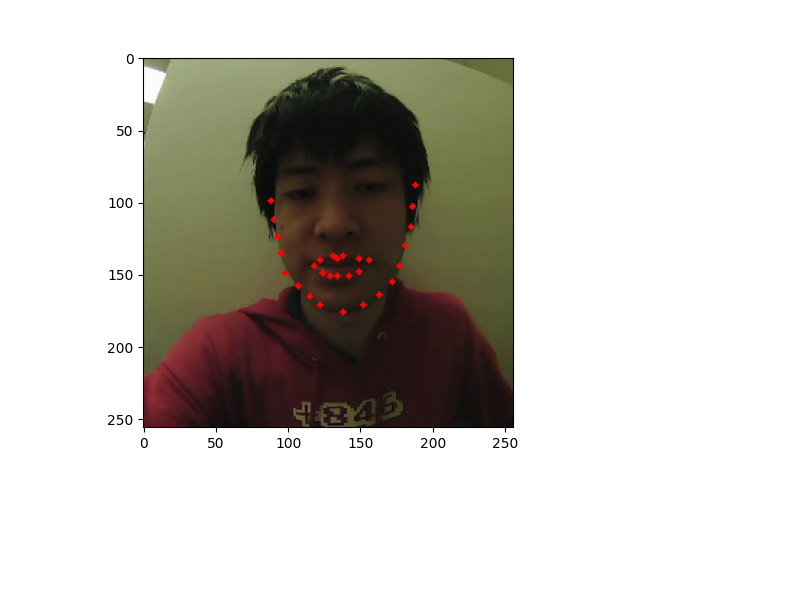

In [4]:
i = 0
landmark_map = []
face_loc = np.zeros(5)
while i < len(regular_video):
    frame = (regular_video[i] * 255)
    preds, _, faces = fa.get_landmarks(frame, return_bboxes=True)
    if preds:
        landmark_map.append([preds[0], frame / 255])
        face_loc += faces[0]
    else:
        print("No face", i)
    i += 1

face_loc = face_loc[:4] / len(landmark_map)
print(faces)
print(face_loc)
if(preds):
    # Jawline, and mouth
    headset_features = np.concatenate((preds[0].astype(int)[:17],preds[0].astype(int)[49:61]))
    draw_marks(frame,headset_features,color = (255,0,0))

plt.imshow(frame/255)

In [5]:
def landmark_diff(la, lb):
    mouth_a = la[49:61]
    mouth_b = lb[49:61]
    mouth_a_normalized = mouth_a - np.mean(mouth_a, axis=1).reshape(-1, 1)
    mouth_b_normalized = mouth_b - np.mean(mouth_b, axis=1).reshape(-1, 1)
    diff = (mouth_a - mouth_b)**2
    return np.sum(diff)

def best_next_frame(current, captured):
    la, img = landmark_map[current]
    preds = fa.get_landmarks(captured, detected_faces=[[*face_loc, 1]])
    if preds is None:
        return current
    lb = preds[0]

    best_i = current
    best_score = landmark_diff(la, lb)
    for i in range(len(landmark_map)):
        score = landmark_diff(landmark_map[i][0], lb)
        if score < best_score:
            best_score = score
            best_i = i
    return best_i, la, lb

In [29]:
## Add the neutral blinking video to the top part
driving_video[0][:MERGE_HEIGHT,:] = regular_video[0][:MERGE_HEIGHT,:]
# cv2.imshow(winname="Face", mat=cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR))


counter = 0
cur_frame = 0
#with pyvirtualcam.Camera(width=256, height=256, fps=30,device='/dev/video5') as cam:
prev_frame = None
while(1):
    start = time.time()
    if not USE_RECORDED_VIDEO:
        res, frame = cap.read()
        if not res:
            print('no frame')
            continue
        cv2.imwrite("normalframe.jpg", frame);
        frame = pre_process_frame(frame)
    else:
        frame = saved_video[counter%len(saved_video)]
        frame = pre_process_frame(frame, crop = False, cvt_color = False)
    #frame[0][:MERGE_HEIGHT,:] = regular_video[counter%len(regular_video)][:MERGE_HEIGHT,:]
    cv2.imshow("input frame", cv2.cvtColor(np.uint8(frame[0]*255), cv2.COLOR_BGR2RGB))

    ## Add the neutral blinking video to the top part
    next_frame, la, lb = best_next_frame(cur_frame, frame[0] * 255)
    cur_frame = next_frame
    frame[0] = landmark_map[next_frame][1].copy()
    if prev_frame is None:
        prev_frame = frame[0]
    
    frame[0] = (0.5*frame[0] + 0.5*prev_frame)
    
    #f1 = np.concatenate((la.astype(int)[:17],la.astype(int)[49:61]))
    #draw_marks(frame[0],f1,color = (255,0,0))
    #f2 = np.concatenate((lb.astype(int)[:17],lb.astype(int)[49:61]))
    #draw_marks(frame[0],f2,color = (0,0,255))
    #frame[0][:MERGE_HEIGHT,:] = regular_video[counter%len(regular_video)][:MERGE_HEIGHT,:]   

    ## debugging visualization
    single_frame = frame[0]
    #draw_marks(single_frame, kp_driving[0].astype(int))
    #tmp = cv2.resize(single_frame,(720,720))
    #tmp[:,:,[0,2]] = tmp[:,:,[2,0]] 
    img = cv2.cvtColor(np.uint8(single_frame*255), cv2.COLOR_BGR2RGB)
    cv2.imshow("split frame", img)
    if counter % 50 == 0 or counter == 175:
        cv2.imwrite(f"frame_{counter}.png", img)
        print("saving frame", counter)
    ch = cv2.waitKey(1)
    if ch == ord('q'):
        cv2.imwrite(f"frame_{counter}.png", img)
        print("saving frame", counter)
        cv2.destroyWindow("split frame")
        cv2.destroyWindow("input frame")
        break
    prev_frame = frame[0]
    counter = (counter+1)%len(regular_video)



saving frame 0
saving frame 50
saving frame 100
saving frame 150
saving frame 175
saving frame 200
saving frame 250
saving frame 300
saving frame 350
saving frame 400
saving frame 0
saving frame 50
saving frame 100
saving frame 150
saving frame 175
saving frame 200
saving frame 250
saving frame 300
saving frame 350
saving frame 359
